In [11]:
from preprocessing import DataLoader
import os
import pandas as pd

base_path = os.path.dirname(os.getcwd()) 
loader = DataLoader(base_path)
loader.load_all_data()

In [12]:
# Expressions-Daten
exprs_data = loader.exprs_data

# Originale pData
pdata_original = loader.pdata_original

# Imputierte pData
pdata_imputed = loader.pdata_imputed

# All Genes Daten
all_genes_data = loader.all_genes_data

# Common Genes Daten
common_genes_data = loader.common_genes_data

# Intersection Daten
intersection_data = loader.intersection_data

# Merged originale pData
merged_pdata_original = loader.merged_pdata_original

# Merged imputierte pData
merged_pdata_imputed = loader.merged_pdata_imputed

In [39]:
x=merged_pdata_imputed['merged_imputed_pData.csv']
x['CEP_STATUS']

Atlanta_2014_Long.PT081                 0
Atlanta_2014_Long.PT127                 0
Atlanta_2014_Long.PT168                 0
Atlanta_2014_Long.PT184                 0
Atlanta_2014_Long.PT199                 0
                                       ..
Stockholm_2016_Ross_Adams.STKHLM8462    0
Stockholm_2016_Ross_Adams.STKHLM8659    1
Stockholm_2016_Ross_Adams.STKHLM9157    0
Stockholm_2016_Ross_Adams.STKHLM9161    0
Stockholm_2016_Ross_Adams.STKHLM9246    1
Name: CEP_STATUS, Length: 1091, dtype: int64

In [26]:
common_genes_data['common_genes_knn_imputed.csv'].isnull().values.any()

False

In [32]:
from preprocessing import DataLoader
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.util import Surv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import xgboost as xgb

In [14]:
# 1. Gradient Boosting Survival Analysis

def fit_boosted_survival(X, y):
    # Basic implementation
    model = GradientBoostingSurvivalAnalysis(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=4,
        validation_fraction=0.2,  
        n_iter_no_change=10,     
        tol=1e-4                 
    )
    gbsa.fit(X, y)
    return gbsa

# 2. Custom Component-Wise Gradient Boosting
class ComponentWiseGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.base_learners = []
        
    def _compute_negative_gradient(self, y_true, y_pred):
        # Compute negative gradient for Cox partial likelihood
        risk_set = np.zeros(len(y_true))
        for i in range(len(y_true)):
            risk_set[i] = np.sum(np.exp(y_pred[y_true['time'] >= y_true['time'][i]]))
        return y_true['status'] - risk_set * np.exp(y_pred)
    
    def fit(self, X, y):
        current_prediction = np.zeros(len(y))
        
        for _ in range(self.n_estimators):
            # Compute negative gradient
            negative_gradient = self._compute_negative_gradient(y, current_prediction)
            
            # Fit base learner to negative gradient
            base_learner = DecisionTreeRegressor(max_depth=2)
            base_learner.fit(X, negative_gradient)
            
            # Update prediction
            current_prediction += self.learning_rate * base_learner.predict(X)
            self.base_learners.append(base_learner)

# 3. XGBoost for Survival

def create_xgboost_survival(X, y):
    # Convert survival data to XGBoost format
    dtrain = xgb.DMatrix(X)
    dtrain.set_float_info('label', y['time'])
    dtrain.set_float_info('weight', y['status'])
    
    params = {
        'objective': 'survival:cox',
        'eval_metric': 'cox-nloglik',
        'eta': 0.1,
        'max_depth': 2,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        early_stopping_rounds=10
    )
    return model

# 4. Combining Multiple Boosting Models
class EnsembleBoostedSurvival:
    def __init__(self):
        self.models = {
            'gbsa': GradientBoostingSurvivalAnalysis(),
            'component_wise': ComponentWiseGradientBoosting(),
            'xgboost': None  # Will be initialized during fitting
        }
        self.weights = None
    
    def fit(self, X, y):
        predictions = {}
        
        # Fit individual models
        self.models['gbsa'].fit(X, y)
        self.models['component_wise'].fit(X, y)
        self.models['xgboost'] = create_xgboost_survival(X, y)
        
        # Get predictions from each model
        for name, model in self.models.items():
            predictions[name] = model.predict(X)
        
        # Optimize weights using validation set
        self.weights = self._optimize_weights(predictions, y)
    
    def predict(self, X):
        predictions = {}
        for name, model in self.models.items():
            predictions[name] = model.predict(X)
        
        # Weighted combination
        final_prediction = sum(w * predictions[m] 
                             for m, w in self.weights.items())
        return final_prediction

In [29]:
import numpy as np
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import pandas as pd

class BoostingSurvivalComparison:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {
            'GradientBoosting': self._create_gradient_boosting(),
            'ComponentwiseGradientBoosting': self._create_componentwise_boosting(),
            'XGBoostSurvival': self._create_xgboost()
        }
        self.results = {}
        
    def _create_gradient_boosting(self):
        return GradientBoostingSurvivalAnalysis(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            loss='coxph',
            random_state=self.random_state
        )
    
    def _create_componentwise_boosting(self):
        return ComponentwiseGradientBoostingSurvivalAnalysis(
            n_estimators=100,
            learning_rate=0.1,
            random_state=self.random_state
        )
    
    def _create_xgboost(self):
        return None  # Will be handled separately due to different interface
    
    def _prepare_data(self, X, y):
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        return X_scaled
    
    def evaluate_models(self, X, y, n_splits=5):
        """
        Evaluate all models using k-fold cross-validation
        
        Parameters:
        X: gene expression data (numpy array or pandas DataFrame)
        y: structured survival data with 'status' and 'time'
        n_splits: number of cross-validation folds
        """
        X = self._prepare_data(X, y)
        
        # Initialize results storage
        self.results = {model_name: {'c_index': []} for model_name in self.models.keys()}
        
        # Create cross-validation splits
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            print(f"\nFold {fold + 1}/{n_splits}")
            
            for model_name, model in self.models.items():
                print(f"\nTraining {model_name}...")
                
                if model_name == 'XGBoostSurvival':
                    c_index = self._fit_and_evaluate_xgboost(X_train, X_test, y_train, y_test)
                else:
                    c_index = self._fit_and_evaluate_model(model, X_train, X_test, y_train, y_test)
                
                self.results[model_name]['c_index'].append(c_index)
                print(f"{model_name} C-index for fold {fold + 1}: {c_index:.4f}")
        
        self._summarize_results()
        return self.results
    
    def _fit_and_evaluate_model(self, model, X_train, X_test, y_train, y_test):
        model.fit(X_train, y_train)
        pred_risk = model.predict(X_test)
        return concordance_index_censored(y_test['status'], y_test['time'], pred_risk)[0]
    
    def _fit_and_evaluate_xgboost(self, X_train, X_test, y_train, y_test):
        # Convert survival data to XGBoost format
        dtrain = xgb.DMatrix(X_train)
        dtrain.set_float_info('label', y_train['time'])
        dtrain.set_float_info('weight', y_train['status'])
        
        dtest = xgb.DMatrix(X_test)
        
        params = {
            'objective': 'survival:cox',
            'eval_metric': 'cox-nloglik',
            'eta': 0.1,
            'max_depth': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        }
        
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=100
        )
        
        pred_risk = model.predict(dtest)
        return concordance_index_censored(y_test['status'], y_test['time'], pred_risk)[0]
    
    def _summarize_results(self):
        print("\nSummary of Results:")
        print("-" * 50)
        for model_name, results in self.results.items():
            c_indices = results['c_index']
            mean_c_index = np.mean(c_indices)
            std_c_index = np.std(c_indices)
            print(f"\n{model_name}:")
            print(f"Mean C-index: {mean_c_index:.4f} (±{std_c_index:.4f})")
            print(f"Min C-index: {min(c_indices):.4f}")
            print(f"Max C-index: {max(c_indices):.4f}")

# Usage example with your data:
def run_boosting_comparison(exprs_data, survival_data):
    # Ensure your survival data is in the correct format
    y = np.array([(status, time) for status, time in 
                  zip(survival_data['BCR_STATUS'], survival_data['MONTH_TO_BCR'])],
                 dtype=[('status', bool), ('time', float)])
    
    # Initialize comparison
    comparison = BoostingSurvivalComparison()
    
    # Run comparison
    results = comparison.evaluate_models(exprs_data, y, n_splits=5)
    
    return comparison, results

# Run the comparison with your data:
exprs = loader.intersection_data['exprs_intersect.csv']
survival_data = loader.merged_pdata_imputed['merged_imputed_pData.csv']

comparison, results = run_boosting_comparison(exprs, survival_data)




Fold 1/5

Training GradientBoosting...
GradientBoosting C-index for fold 1: 0.7116

Training ComponentwiseGradientBoosting...
ComponentwiseGradientBoosting C-index for fold 1: 0.6531

Training XGBoostSurvival...
XGBoostSurvival C-index for fold 1: 0.5395

Fold 2/5

Training GradientBoosting...
GradientBoosting C-index for fold 2: 0.6601

Training ComponentwiseGradientBoosting...
ComponentwiseGradientBoosting C-index for fold 2: 0.6835

Training XGBoostSurvival...
XGBoostSurvival C-index for fold 2: 0.6406

Fold 3/5

Training GradientBoosting...
GradientBoosting C-index for fold 3: 0.7171

Training ComponentwiseGradientBoosting...
ComponentwiseGradientBoosting C-index for fold 3: 0.6842

Training XGBoostSurvival...
XGBoostSurvival C-index for fold 3: 0.5862

Fold 4/5

Training GradientBoosting...
GradientBoosting C-index for fold 4: 0.6678

Training ComponentwiseGradientBoosting...
ComponentwiseGradientBoosting C-index for fold 4: 0.6875

Training XGBoostSurvival...
XGBoostSurvival C-i

c-score:0.7146
 6934 mit merged data ,676 mit intersection data
 6711



C-index with clinical features: 0.7286

Top 10 most important features:
                feature  importance
11761   ENSG00000175063    0.077832
15505  PATH_T_STAGE_T3B    0.063581
13783   ENSG00000196917    0.046256
5871    ENSG00000133107    0.038455
8836    ENSG00000157933    0.031291
1602    ENSG00000088325    0.024952
13228   ENSG00000186340    0.020239
11465   ENSG00000172932    0.018254
1427    ENSG00000082556    0.015919
1553    ENSG00000086991    0.015060


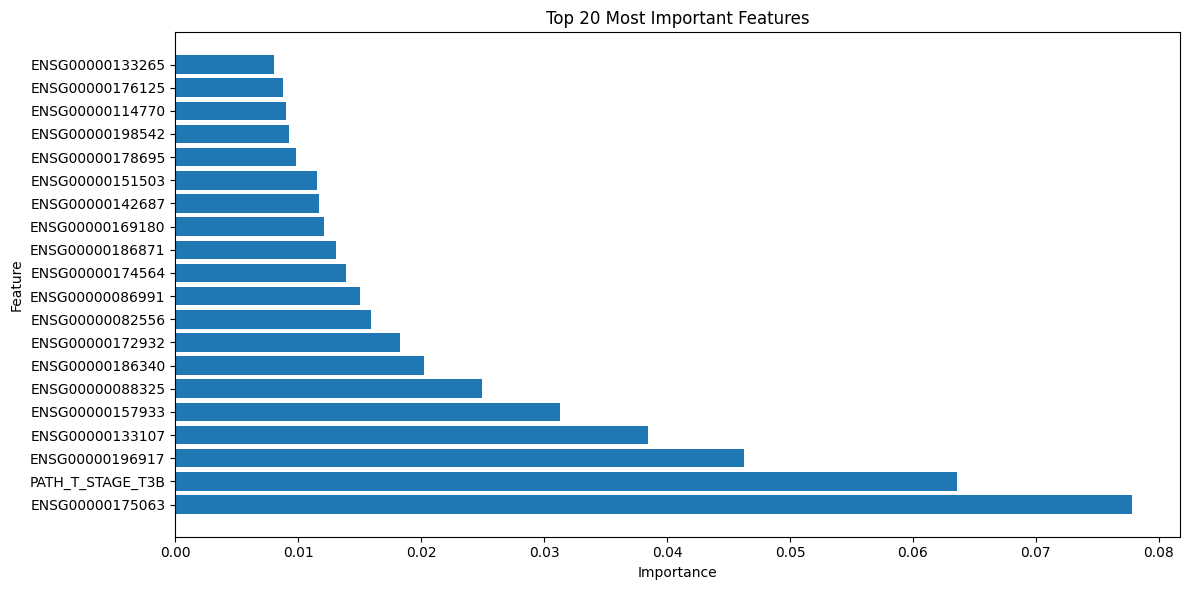

In [35]:
def prepare_clinical_features(pdata):
    """
    Prepare clinical features from pData
    """
    # Select relevant clinical features
    clinical_features = ['GLEASON_SCORE', 'PATH_T_STAGE', 'CLIN_T_STAGE', 'PRE_OPERATIVE_PSA']
    
    # Create copy to avoid modifying original data
    clinical_data = pdata[clinical_features].copy()
    
    # Convert categorical variables to dummy variables
    categorical_features = ['PATH_T_STAGE', 'CLIN_T_STAGE']
    clinical_data = pd.get_dummies(
        clinical_data, 
        columns=categorical_features, 
        drop_first=True,
        prefix=categorical_features
    )
    
    # Handle missing values in numerical columns
    numerical_columns = ['GLEASON_SCORE', 'PRE_OPERATIVE_PSA']
    clinical_data[numerical_columns] = clinical_data[numerical_columns].fillna(
        clinical_data[numerical_columns].median()
    )
    
    return clinical_data

def run_boosting_comparison_with_clinical(exprs_data, pdata, survival_data):
    """
    Run gradient boosting with both genetic and clinical data
    """
    # Prepare clinical features
    clinical_data = prepare_clinical_features(pdata)
    
    # Combine genetic and clinical data
    combined_features = pd.concat([
        exprs_data,
        clinical_data
    ], axis=1)
    
    # Create survival array
    y = np.array([(status, time) for status, time in 
                  zip(survival_data['BCR_STATUS'], survival_data['MONTH_TO_BCR'])],
                 dtype=[('status', bool), ('time', float)])
    
    # Create and run gradient boosting model
    model = GradientBoostingSurvivalAnalysis(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=4,
        validation_fraction=0.2,  
        n_iter_no_change=10,     
        tol=1e-4                 
    )
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        combined_features, y, test_size=0.2, random_state=42
    )
    
    # Fit model
    model.fit(X_train, y_train)    # Changed from gb_model to model
    
    # Get predictions
    pred_risk = model.predict(X_test)   # Changed from gb_model to model
    c_index = concordance_index_censored(y_test['status'], y_test['time'], pred_risk)[0]
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': combined_features.columns,
        'importance': model.feature_importances_    
    }).sort_values('importance', ascending=False)
    
    return model, c_index, feature_importance

# Run the comparison
exprs = common_genes_data['common_genes_knn_imputed.csv']
pdata = loader.merged_pdata_imputed['merged_imputed_pData.csv']
survival_data = loader.merged_pdata_imputed['merged_imputed_pData.csv']

model, c_index, feature_importance = run_boosting_comparison_with_clinical(
    exprs, pdata, survival_data
)

print(f"\nC-index with clinical features: {c_index:.4f}")
print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Optional: Visualize feature importance
import matplotlib.pyplot as plt

def plot_feature_importance(feature_importance, top_n=20):
    plt.figure(figsize=(12, 6))
    top_features = feature_importance.head(top_n)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance(feature_importance)

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import RobustScaler

def prepare_clinical_features(pdata):
    """
    Enhanced clinical feature preparation
    """
    # Add more potentially relevant clinical features
    clinical_features = [
        'GLEASON_SCORE',
        'PATH_T_STAGE', 'CLIN_T_STAGE', 
        'PRE_OPERATIVE_PSA', 'AGE'
    ]
    
    clinical_data = pdata[clinical_features].copy()
    
    # Enhanced categorical handling
    categorical_features = ['PATH_T_STAGE', 'CLIN_T_STAGE']
    clinical_data = pd.get_dummies(
        clinical_data, 
        columns=categorical_features, 
        drop_first=True,
        prefix=categorical_features
    )
    
    # More sophisticated missing value imputation
    numerical_columns = ['GLEASON_SCORE', 
                        'PRE_OPERATIVE_PSA', 'AGE']
    
    # Use different strategies for different types of missing values
    for col in numerical_columns:
        if col in ['GLEASON_SCORE']:
            clinical_data[col] = clinical_data[col].fillna(clinical_data[col].mode()[0])
        else:
            clinical_data[col] = clinical_data[col].fillna(clinical_data[col].median())
    
    # Add interaction terms for important clinical features
    clinical_data['GLEASON_PSA_INTERACTION'] = clinical_data['GLEASON_SCORE'] * clinical_data['PRE_OPERATIVE_PSA']
    
    return clinical_data

def select_important_genes(exprs_data, y, n_features=1000):
    """
    Pre-select important genetic features
    """
    selector = SelectFromModel(
        GradientBoostingSurvivalAnalysis(
            n_estimators=500,
            learning_rate=0.01,
            max_depth=3
        ),
        max_features=n_features
    )
    selector.fit(exprs_data, y)
    return selector.transform(exprs_data), selector.get_feature_names_out()

def run_boosting_comparison_with_clinical(exprs_data, pdata, survival_data):
    """
    Enhanced gradient boosting with extensive tuning
    """
    # Prepare clinical features
    clinical_data = prepare_clinical_features(pdata)
    
    # Create survival array
    y = np.array([(status, time) for status, time in 
                  zip(survival_data['BCR_STATUS'], survival_data['MONTH_TO_BCR'])],
                 dtype=[('status', bool), ('time', float)])
    
    # Pre-select important genes
    selected_exprs, selected_genes = select_important_genes(exprs_data, y)
    
    # Combine features
    combined_features = pd.concat([
        pd.DataFrame(selected_exprs, index=exprs_data.index, columns=selected_genes),
        clinical_data
    ], axis=1)
    
    # Create cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('gb', GradientBoostingSurvivalAnalysis())
    ])
    
    # Define parameter grid
    param_grid = {
        'gb__n_estimators': [500, 1000],
        'gb__learning_rate': [0.01, 0.005],
        'gb__max_depth': [3, 4, 5],
        'gb__min_samples_split': [5, 10],
        'gb__min_samples_leaf': [3, 5],
        'gb__subsample': [0.8, 1.0],
        'gb__max_features': ['sqrt', None]
    }
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=lambda estimator, X, y: concordance_index_censored(
            y['status'],
            y['time'],
            estimator.predict(X)
        )[0],
        n_jobs=-1,  # Use all available cores
        verbose=2
    )
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        combined_features, y, test_size=0.2, random_state=42, stratify=y['status']
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Get predictions
    pred_risk = best_model.predict(X_test)
    c_index = concordance_index_censored(y_test['status'], y_test['time'], pred_risk)[0]
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': combined_features.columns,
        'importance': best_model.named_steps['gb'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Print detailed results
    print("\nBest parameters:", grid_search.best_params_)
    print("\nCross-validation results:")
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print(cv_results[['params', 'mean_test_score', 'std_test_score']])
    
    return best_model, c_index, feature_importance, grid_search

# Run with enhanced monitoring
model, c_index, feature_importance, grid_search = run_boosting_comparison_with_clinical(
    exprs, pdata, survival_data
)

# Enhanced visualization
def plot_detailed_results(feature_importance, grid_search, c_index):
    plt.figure(figsize=(15, 10))
    
    # Feature importance plot
    plt.subplot(2, 1, 1)
    top_features = feature_importance.head(20)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.title(f'Top 20 Most Important Features (C-index: {c_index:.4f})')
    plt.xlabel('Importance')
    
    # Learning curves
    plt.subplot(2, 1, 2)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    plt.plot(cv_results['mean_test_score'], label='Mean CV Score')
    plt.fill_between(
        range(len(cv_results)),
        cv_results['mean_test_score'] - cv_results['std_test_score'],
        cv_results['mean_test_score'] + cv_results['std_test_score'],
        alpha=0.3
    )
    plt.title('Cross-validation Learning Curves')
    plt.xlabel('Parameter Combination')
    plt.ylabel('C-index')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_detailed_results(feature_importance, grid_search, c_index)

KeyboardInterrupt: 

#### Including Batch effects. Curretnly not trained with sufficent params but interestingly Gleason Score is now relevant

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

class BatchAwareSurvivalModel:
    def __init__(self):
        self.scaler = StandardScaler()
        self.base_model = GradientBoostingSurvivalAnalysis(
            n_estimators=10,
            learning_rate=0.1,
            max_depth=3
        )
        
    def _extract_batch_info(self, data):
        """Extrahiert Batch-Information aus den Index-Namen"""
        return data.index.map(lambda x: x.split('.')[0])
    
    def _center_within_batch(self, X, batch_ids):
        """Zentriert Features innerhalb jedes Batches"""
        X_centered = X.copy()
        for batch in np.unique(batch_ids):
            mask = batch_ids == batch
            X_centered.loc[mask] = self.scaler.fit_transform(X.loc[mask])
        return X_centered
    
    def fit(self, X, y):
        """
        X: Feature-Matrix (gene expression + clinical)
        y: Survival data (status, time)
        """
        # Batch-Information extrahieren
        batch_ids = self._extract_batch_info(X)
        
        # Batch-Korrektur durchführen
        X_corrected = self._center_within_batch(X, batch_ids)
        
        # Basis-Modell fitten
        self.base_model.fit(X_corrected, y)
        
    def predict(self, X):
        # Batch-Korrektur für Vorhersage
        batch_ids = self._extract_batch_info(X)
        X_corrected = self._center_within_batch(X, batch_ids)
        return self.base_model.predict(X_corrected)
    
    def get_feature_importance(self):
        return pd.Series(
            self.base_model.feature_importances_,
            index=self.base_model.feature_names_in_
        )

def evaluate_model_with_cv(X, y, n_splits=5):
    """Evaluiert das Modell mit Cross-Validation"""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    c_indices = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Daten für diesen Fold aufteilen
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        # Modell trainieren und evaluieren
        model = BatchAwareSurvivalModel()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        # C-Index berechnen
        c_index = concordance_index_censored(
            y_test['status'],
            y_test['time'],
            pred
        )[0]
        
        c_indices.append(c_index)
        print(f"Fold {fold+1} C-index: {c_index:.3f}")
    
    return np.mean(c_indices), np.std(c_indices)

def plot_results(feature_importance, c_index_mean, c_index_std):
    """Visualisiert die Ergebnisse"""
    plt.figure(figsize=(12, 6))
    
    # Top 20 wichtigste Features
    top_features = feature_importance.sort_values(ascending=True)[-20:]
    
    plt.barh(range(len(top_features)), top_features)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Features (C-index: {c_index_mean:.3f} ± {c_index_std:.3f})')
    plt.tight_layout()
    plt.show()

# Hauptausführung
def main():
    # Daten laden
    exprs = loader.common_genes_data['common_genes_knn_imputed.csv']
    pdata = loader.merged_pdata_imputed['merged_imputed_pData.csv']
    
    # Survival Array erstellen
    y = np.array([(status, time) for status, time in 
                  zip(pdata['BCR_STATUS'], pdata['MONTH_TO_BCR'])],
                 dtype=[('status', bool), ('time', float)])
    
    # Klinische Features vorbereiten
    clinical_features = ['GLEASON_SCORE', 'PATH_T_STAGE', 'PRE_OPERATIVE_PSA']
    clinical_data = pd.get_dummies(
        pdata[clinical_features], 
        columns=['PATH_T_STAGE']
    )
    
    # Genetische und klinische Daten kombinieren
    combined_features = pd.concat([exprs, clinical_data], axis=1)
    
    # Modell evaluieren
    c_index_mean, c_index_std = evaluate_model_with_cv(combined_features, y)
    
    # Finales Modell für Feature Importance
    final_model = BatchAwareSurvivalModel()
    final_model.fit(combined_features, y)
    feature_importance = final_model.get_feature_importance()
    
    # Ergebnisse plotten
    plot_results(feature_importance, c_index_mean, c_index_std)
    
    print(f"\nOverall C-index: {c_index_mean:.3f} (±{c_index_std:.3f})")
    print("\nTop 10 most important features:")
    print(feature_importance.sort_values(ascending=False).head(10))

if __name__ == "__main__":
    from preprocessing import DataLoader
    import os
    
    # DataLoader initialisieren
    base_path = os.path.dirname(os.getcwd())
    loader = DataLoader(base_path)
    loader.load_all_data()
    
    main()

### Ensemle mit RSF und Compontent wise GB (Params noch nicht gefixed)

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

class SurvivalEnsemble:
    def __init__(self):
        # Initialisiere beide Modelle mit einfachen Parametern
        self.rsf = RandomSurvivalForest(
            n_estimators=10,
            max_depth=3,
            n_jobs=-1,
            random_state=42
        )
        
        self.cgb = ComponentwiseGradientBoostingSurvivalAnalysis(
            n_estimators=10,
            learning_rate=0.1,
            random_state=42
        )
        
        self.scaler = StandardScaler()
        
    def fit(self, X, y):
        # Standardisiere Features
        X_scaled = pd.DataFrame(
            self.scaler.fit_transform(X),
            index=X.index,
            columns=X.columns
        )
        
        # Fitte beide Modelle
        self.rsf.fit(X_scaled, y)
        self.cgb.fit(X_scaled, y)
        
    def predict(self, X):
        # Standardisiere Features
        X_scaled = pd.DataFrame(
            self.scaler.transform(X),
            index=X.index,
            columns=X.columns
        )
        
        # Hole Vorhersagen
        pred_rsf = self.rsf.predict(X_scaled)
        pred_cgb = self.cgb.predict(X_scaled)
        
        # Kombiniere Vorhersagen (einfacher Durchschnitt)
        return (pred_rsf + pred_cgb) / 2

def evaluate_ensemble():
    # Daten laden
    exprs = loader.common_genes_data['common_genes_knn_imputed.csv']
    pdata = loader.merged_pdata_imputed['merged_imputed_pData.csv']
    
    # Survival Array erstellen
    y = np.array([(status, time) for status, time in 
                  zip(pdata['BCR_STATUS'], pdata['MONTH_TO_BCR'])],
                 dtype=[('status', bool), ('time', float)])
    
    # Klinische Features vorbereiten
    clinical_features = ['GLEASON_SCORE', 'PATH_T_STAGE', 'PRE_OPERATIVE_PSA']
    clinical_data = pd.get_dummies(
        pdata[clinical_features], 
        columns=['PATH_T_STAGE']
    )
    
    # Features kombinieren
    X = pd.concat([exprs, clinical_data], axis=1)
    
    # Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_indices = []
    
    # Progress Tracking
    total_folds = 5
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        print(f"\nStarting Fold {fold}/{total_folds} ({fold/total_folds*100:.1f}% complete)")
        
        # Split data
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        # Train ensemble
        print("Training Random Survival Forest...")
        ensemble = SurvivalEnsemble()
        ensemble.fit(X_train, y_train)
        
        # Make predictions
        print("Making predictions...")
        pred = ensemble.predict(X_test)
        
        # Calculate c-index
        c_index = concordance_index_censored(
            y_test['status'],
            y_test['time'],
            pred
        )[0]
        
        c_indices.append(c_index)
        print(f"Fold {fold} C-index: {c_index:.3f}")
    
    # Final results
    mean_c_index = np.mean(c_indices)
    std_c_index = np.std(c_indices)
    
    print("\nFinal Results:")
    print(f"Mean C-index: {mean_c_index:.3f} (±{std_c_index:.3f})")
    print("Individual fold C-indices:", c_indices)
    
    return mean_c_index, std_c_index

if __name__ == "__main__":
    from preprocessing import DataLoader
    import os
    
    # DataLoader initialisieren
    base_path = os.path.dirname(os.getcwd())
    loader = DataLoader(base_path)
    loader.load_all_data()
    
    # Daten laden
    common_genes_data = loader.common_genes_data
    
    # Evaluation durchführen
    mean_c_index, std_c_index = evaluate_ensemble()


Starting Fold 1/5 (20.0% complete)
Training Random Survival Forest...
Making predictions...
Fold 1 C-index: 0.638

Starting Fold 2/5 (40.0% complete)
Training Random Survival Forest...
Making predictions...
Fold 2 C-index: 0.643

Starting Fold 3/5 (60.0% complete)
Training Random Survival Forest...
Making predictions...
Fold 3 C-index: 0.604

Starting Fold 4/5 (80.0% complete)
Training Random Survival Forest...
Making predictions...
Fold 4 C-index: 0.633

Starting Fold 5/5 (100.0% complete)
Training Random Survival Forest...
Making predictions...
Fold 5 C-index: 0.679

Final Results:
Mean C-index: 0.640 (±0.024)
Individual fold C-indices: [0.6382246376811594, 0.643376296152728, 0.6042834983892137, 0.6331886753461459, 0.6789406320764005]


### Ensemble zwischen Neural Net, Component wise GB und RSF (params noch nicht gefixed)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

class DeepSurvivalNet(nn.Module):
    def __init__(self, input_dim):
        super(DeepSurvivalNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net(x)

class SurvivalLoss(nn.Module):
    def forward(self, pred, time, event):
        # Cox Partial Likelihood Loss
        mask = event.bool()
        log_risk = pred
        max_log_risk = torch.max(log_risk)
        log_risk = log_risk - max_log_risk
        exp_risk = torch.exp(log_risk)
        
        risk_set = torch.zeros_like(time, dtype=torch.float32)
        for i in range(len(time)):
            risk_set[i] = torch.sum(exp_risk[time >= time[i]])
            
        log_likelihood = log_risk[mask] - torch.log(risk_set[mask])
        loss = -torch.mean(log_likelihood)
        return loss

class SurvivalEnsemble:
    def __init__(self):
        self.rsf = RandomSurvivalForest(
            n_estimators=10,
            max_depth=3,
            n_jobs=-1,
            random_state=42
        )
        
        self.cgb = ComponentwiseGradientBoostingSurvivalAnalysis(
            n_estimators=10,
            learning_rate=0.1,
            random_state=42
        )
        
        self.scaler = StandardScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def _init_neural_net(self, input_dim):
        self.nn_model = DeepSurvivalNet(input_dim).to(self.device)
        self.criterion = SurvivalLoss()
        self.optimizer = torch.optim.Adam(self.nn_model.parameters(), lr=0.001)
        
    def _train_neural_net(self, X, y, epochs=10, batch_size=32):
        X_tensor = torch.FloatTensor(X.values).to(self.device)
        time_tensor = torch.FloatTensor(y['time']).to(self.device)
        event_tensor = torch.FloatTensor(y['status']).to(self.device)
        
        dataset = torch.utils.data.TensorDataset(X_tensor, time_tensor, event_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(epochs):
            self.nn_model.train()
            total_loss = 0
            for batch_x, batch_time, batch_event in dataloader:
                self.optimizer.zero_grad()
                pred = self.nn_model(batch_x)
                loss = self.criterion(pred, batch_time, batch_event)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")
                
    def _predict_neural_net(self, X):
        self.nn_model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X.values).to(self.device)
            pred = self.nn_model(X_tensor)
            return pred.cpu().numpy().flatten()
        
    def fit(self, X, y):
        # Standardisiere Features
        X_scaled = pd.DataFrame(
            self.scaler.fit_transform(X),
            index=X.index,
            columns=X.columns
        )
        
        # Fitte klassische Modelle
        self.rsf.fit(X_scaled, y)
        self.cgb.fit(X_scaled, y)
        
        # Initialisiere und trainiere Neural Net
        self._init_neural_net(X.shape[1])
        self._train_neural_net(X_scaled, y)
        
    def predict(self, X):
        # Standardisiere Features
        X_scaled = pd.DataFrame(
            self.scaler.transform(X),
            index=X.index,
            columns=X.columns
        )
        
        # Hole Vorhersagen von allen Modellen
        pred_rsf = self.rsf.predict(X_scaled)
        pred_cgb = self.cgb.predict(X_scaled)
        pred_nn = self._predict_neural_net(X_scaled)
        
        # MinMax-Skalierung für Neural Net Predictions
        pred_nn = (pred_nn - pred_nn.min()) / (pred_nn.max() - pred_nn.min())
        
        # Kombiniere Vorhersagen (gewichteter Durchschnitt)
        return (pred_rsf + pred_cgb + pred_nn) / 3

def evaluate_ensemble():
    # Daten laden
    exprs = loader.common_genes_data['common_genes_knn_imputed.csv']
    pdata = loader.merged_pdata_imputed['merged_imputed_pData.csv']
    
    # Survival Array erstellen
    y = np.array([(status, time) for status, time in 
                  zip(pdata['BCR_STATUS'], pdata['MONTH_TO_BCR'])],
                 dtype=[('status', bool), ('time', float)])
    
    # Klinische Features vorbereiten
    clinical_features = ['GLEASON_SCORE', 'PATH_T_STAGE', 'PRE_OPERATIVE_PSA']
    clinical_data = pd.get_dummies(
        pdata[clinical_features], 
        columns=['PATH_T_STAGE']
    )
    
    # Features kombinieren
    X = pd.concat([exprs, clinical_data], axis=1)
    
    # Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_indices = []
    
    # Progress Tracking
    total_folds = 5
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        print(f"\nStarting Fold {fold}/{total_folds} ({fold/total_folds*100:.1f}% complete)")
        
        # Split data
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        # Train ensemble
        print("Training Ensemble...")
        ensemble = SurvivalEnsemble()
        ensemble.fit(X_train, y_train)
        
        # Make predictions
        print("Making predictions...")
        pred = ensemble.predict(X_test)
        
        # Calculate c-index
        c_index = concordance_index_censored(
            y_test['status'],
            y_test['time'],
            pred
        )[0]
        
        c_indices.append(c_index)
        print(f"Fold {fold} C-index: {c_index:.3f}")
    
    # Final results
    mean_c_index = np.mean(c_indices)
    std_c_index = np.std(c_indices)
    
    print("\nFinal Results:")
    print(f"Mean C-index: {mean_c_index:.3f} (±{std_c_index:.3f})")
    print("Individual fold C-indices:", c_indices)
    
    return mean_c_index, std_c_index

if __name__ == "__main__":
    from preprocessing import DataLoader
    import os
    
    # DataLoader initialisieren
    base_path = os.path.dirname(os.getcwd())
    loader = DataLoader(base_path)
    loader.load_all_data()
    
    # Daten laden
    common_genes_data = loader.common_genes_data
    
    # Evaluation durchführen
    mean_c_index, std_c_index = evaluate_ensemble()